In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import umap
from scipy.signal import savgol_filter
import sys
from torch.utils.tensorboard import SummaryWriter

# Model

In [2]:
"""
Module representing a vector quantization layer. Takes input data, reshapes it
from BCHW to BHWC, flattens it to (BHW, C), then looks up the nearest vector in
an embedding for al BHW vectors.
"""
class VectorQuantizer(nn.Module):

    """
    Constructor to create layer. Uses num_embeddings and embedding_dim to create
    and embedding layer, where embedding_dim (D in reference paper) must match the 
    C of the input data that will be passed in. Beta is equivalent to commitment 
    cost.
    """
    def __init__(self, num_embeddings, embedding_dim, beta, decay=0.99, epsilon=1e-5):

        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self.beta = beta

        # Initializing embedding
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    """
    Defines forward pass of data through the quantization layer. 
    """
    def forward(self, x):

        # Convert inputs from BCHW to BHWC then flattens to (BHW, C)
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape
        flat_x = x.view(-1, self._embedding_dim) #(-1, 1, 1, K)

        # Calculate distances from each vector in the flattened input to vectors
        # in the embedding according to ||z - e||2 Where z is vector of input data
        # and e is a vector in the embedding. Output will be (BHW, D).
        distances = (torch.sum(flat_x**2, dim=1, keepdim=True) 
            + torch.sum(self._embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_x, self._embedding.weight.t()))

        # Take argmin to find the closest matching vector in embedding to the input
        # vectors. This give the indices of the vectors from the embedding to be
        # used which will be quantized and unflattened.
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_x)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x)
        loss = self.beta * e_latent_loss
        
        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [3]:
"""
Single residual layer as parts of ResNets. Each block is implemented as
A 2D convolution operation, relu, 2D convolution operation, relu, followed
by a 2D convolution operation to match output channels. The output of this 
is then added to the input.
"""
class ResidualBlock(nn.Module):

    """
    Constructor to build a residual block.
    """
    def __init__(self, in_channels, residual_hiddens=256):

        super(ResidualBlock, self).__init__()

        # TODO Batch norm?
        self.residual_block = nn.Sequential(

            nn.Conv2d(in_channels, residual_hiddens,
                kernel_size=3, padding=1),
            
            nn.ReLU(True),
            
            nn.Conv2d(residual_hiddens, in_channels,
                kernel_size=1),
            
            nn.ReLU(True)
        )

    """
    Defines forward pass through the residual block where the
    input is added to output of conv operations.
    """
    def forward(self, x):

        return x + self.residual_block(x)

In [4]:
"""
Encoder pipeline of the VQ-VAE. Contains the convolutional 
residual blocks.
"""
class Encoder(nn.Module):

    """
    Encoder constructor.
    """
    def __init__(self):

        super(Encoder, self).__init__()

        self.convs = nn.Sequential(
        
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, padding=1)
        
        )
        
        self.residual_stack = nn.Sequential(

            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32),
            nn.ReLU(True)

        )

    """
    Defines forward pass through the encoder.
    """
    def forward(self, x):

        x = self.convs(x)
        return self.residual_stack(x)

In [5]:
"""
Decoder pipeline of the VQ-VAE. Contains the deconvolutional 
residual blocks
"""
class Decoder(nn.Module):

    """
    Decoder constructor.
    """
    def __init__(self):

        super(Decoder, self).__init__()
        
        self.conv = nn.Conv2d(64, 32, 3, stride=1, padding=1)

        self.residual_stack = nn.Sequential(


            ResidualBlock(32),
            ResidualBlock(32),
            ResidualBlock(32),
            nn.ReLU(True)

        )
        
        self.conv_trans = nn.Sequential(
        
            nn.ConvTranspose2d(32, 16, 3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1)
            
        )

    """
    Defines forward pass through the decoder.
    """
    def forward(self, x):
        
        x = self.conv(x)
        x = self.residual_stack(x)
        return self.conv_trans(x)

In [6]:
"""
Full VQ-VAE model that combines the flow of input data through the
encoder, quantization block, and decoder.
"""
class VVQModel(nn.Module):

    """
    VQ-VAE constructor that takes parameters for the quantization block.
    """
    def __init__(self, num_embeddings, embedding_dim, beta):

        super(VVQModel, self).__init__()

        self.encoder = Encoder()
        self.conv = nn.Conv2d(32, 64, 3, padding=1)
        self.decoder = Decoder()

        self.vector_quantizer = VectorQuantizer(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim, 
            beta=beta)

    """
    Defines forward pass through the VQ-VAE and returns
    necessary loss metrics.
    """
    def forward(self, x):

        x = self.encoder(x)
        x = self.conv(x)
        loss, quantized, perplexity, _ = self.vector_quantizer(x)
        x_recon = self.decoder(quantized)

        return loss, x_recon, perplexity

# Data Loading

In [7]:
# download and transform train dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

train_dataloader = torch.utils.data.DataLoader(train_data, 
                             batch_size=256, 
                             shuffle=True,
                             pin_memory=True)

# download and transform test dataset
test_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

test_dataloader = torch.utils.data.DataLoader(test_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# Model Training

In [8]:
"""
HYPERPARAMETERS
"""
learning_rate = 1e-3
num_embeddings = 512
num_epochs = 70
embedding_dim = 64
beta = 0.25
"""
HYPERPARAMETERS
"""

model = nn.DataParallel(VVQModel(
    num_embeddings = num_embeddings,
    embedding_dim = embedding_dim,
    beta = beta
)).to(torch.device('cuda'))

train_res_recon_error = []
train_res_perplexity = []

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
data_variance = np.var(train_data.data / 255.0)

writer = SummaryWriter()

for epoch in range(num_epochs):

    epoch_recon_error = 0
    epoch_perplexity_error = 0
    
    model.train()
    
    for batch, _ in train_dataloader:
        batch = batch.to(torch.device('cuda'))
        optimizer.zero_grad()
        vq_loss, data_reconstructed, perplexity = model(batch)

        reconstructed_error = F.mse_loss(data_reconstructed, batch) / data_variance
        loss = reconstructed_error + vq_loss
        loss.sum().backward()
        optimizer.step()

        epoch_recon_error += reconstructed_error.item()
        epoch_perplexity_error += perplexity.sum(dim=0).item()
        
        
    epoch_recon_error = epoch_recon_error / len(train_dataloader.dataset)
    epoch_perplexity_error = epoch_perplexity_error / len(train_dataloader.dataset)
    
    writer.add_scalar('Training Reconstruction Loss', epoch_recon_error, epoch)
    writer.add_scalar('Training Perplexity', epoch_perplexity_error, epoch)
    
    train_res_recon_error.append(epoch_recon_error)
    train_res_perplexity.append(epoch_perplexity_error)

    sys.stdout.write('\rEpoch- %d' % (epoch + 1))

/home/myid/asp55565/miniconda3/envs/PD/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch- 70

# Error Visualization

Text(0.5, 0, 'iteration')

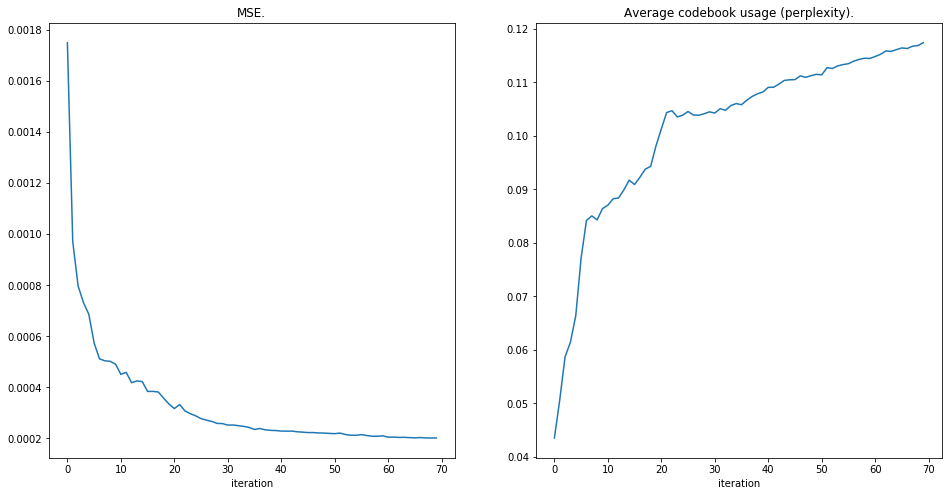

In [9]:
train_res_recon_error_smooth = train_res_recon_error
train_res_perplexity_smooth = train_res_perplexity
# train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
# train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_title('MSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

# Model Evaluation Visualization

Text(0.5, 1.0, 'Reconstructed Input')

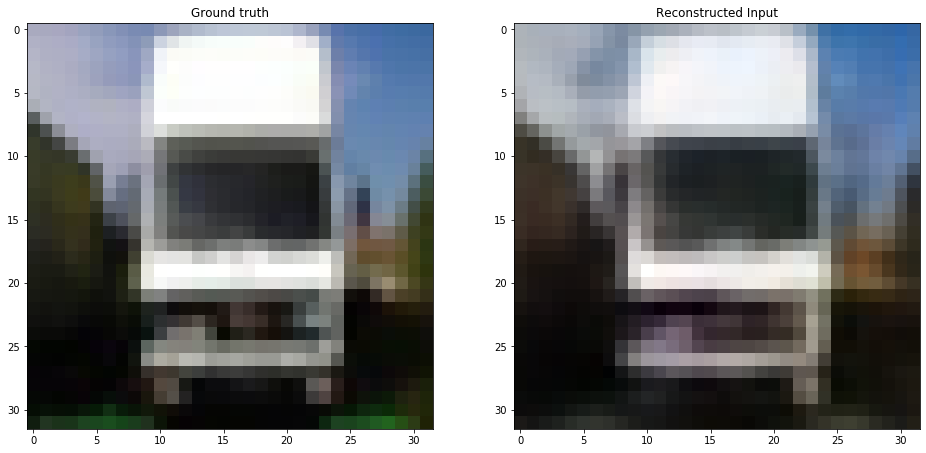

In [17]:
model.eval()
(data, _) = next(iter(test_dataloader))
data = data.to(torch.device('cuda'))

_, reconstructed_data, _ = model(data)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ground_truth = np.transpose((data[0].cpu().data + 0.5), (1, 2, 0))
ax.imshow(ground_truth)
ax.set_title('Ground truth')

ax = f.add_subplot(1,2,2)
reconstructed = np.transpose(reconstructed_data[0].cpu().data + 0.5, (1, 2, 0))
ax.imshow(reconstructed)
ax.set_title('Reconstructed Input')

# Embedding Visualization

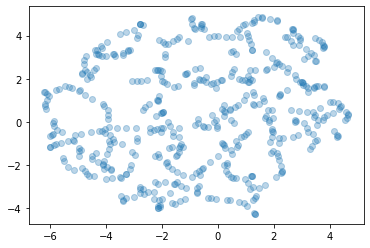

In [11]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model.module.vector_quantizer._embedding.weight.data.cpu())

plt.scatter(proj[:,0], proj[:,1], alpha=0.3)